In [1]:
# mv this notebook in src folder
# or
# set sys path to src folder
import os
import sys

path_to_scr_folder=os.path.join(os.path.dirname(os.path.abspath('')), 'src')
sys.path.append(path_to_scr_folder)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from pbp_alignment import (
              combine_swpa_pbp_alignment,
              load_config,
              run_chromatogram_alignment,
)
from read_chroma import read_only_chroma

# Algorithm Usage Instructions

## Prerequisites
Before running the code, you need to prepare a configuration file with the following structure:

```json
{
  "instrument_parameters": {
    "PRECISION": 2,  // Decimal precision for m/z values (e.g., 2 for 0.01 precision)
    "INT_THRESHOLD": 0,  // Signal intensity threshold (integer or float)
    "MODTIME": 8.1,  // Modulation time in seconds (float)
    "DRIFT_MS": 0  // Drift mass spectrum adjustment (integer). If set to 1, all m/z values are incremented by 1 (e.g., m/z 300 becomes m/z 301)
  },
  "model_choice_parameters": {
    "TYPICAL_PEAK_WIDTH": [1, 5],  // Typical peak widths in pixels or time units
    "MODEL_CHOICE": "normal",  // Alignment model: "normal" or "DualSibson"
    "UNITS": "pixel"  // Units for peak width: "pixel" or "time"
  },
  "io_parameters": {
    "INPUT_PATH": "/path/to/input/",  // Directory containing input chromatograms
    "OUTPUT_PATH": "/path/to/output/",  // Directory for saving the aligned chromatogram
    "REFERENCE_CHROMATOGRAM_FILE": "reference.cdf",  // Reference chromatogram filename
    "TARGET_CHROMATOGRAM_FILE": "target.cdf",  // Target chromatogram filename
    "REFERENCE_ALIGNMENT_PTS_FILE": "alignment_ref.csv",  // Reference alignment points file
    "TARGET_ALIGNMENT_PTS_FILE": "alignment_target.csv"  // Target alignment points file
  }
}
```

---

## Alignment Points Selection
The algorithm requires selecting alignment points that correspond to peaks identified in both the reference and target chromatograms. According to the paper by [Y. Zushi et al.](https://doi.org/10.1016/j.chroma.2017.05.065):

> Alignment points are chosen according to the following criteria:  
> (a) They are present in both the target and reference chromatograms.  
> (b) They bound the region of interest in the chromatogram.  
> (c) They are sufficiently few to be easily managed.

The authors also recommend using at least 10 alignment points to improve retention time accuracy with the alignment algorithm.

---

### Alignment Points Format
The alignment points should be saved in CSV files with the following format (dimension 1, dimension 2):

```csv
17,7
23,9
30,11
...
200,50
```

If the `UNITS` parameter is set to `time` in the configuration file, the points can also be specified in retention time units.

---

## Input and Output Directories
The configuration file must specify:

- **Input directory**: This directory should contain the reference and target chromatograms in CDF format.
- **Output directory**: This is where the aligned chromatogram will be saved.



In [4]:
config_path = os.path.join(os.getcwd(), "..", "config", "pbp_pixel_config.json")
config = load_config(config_path)
run_chromatogram_alignment(config)

Running the main script.
Loading chromatograms and alignment points...
Chromatograms loaded successfully.
Loading alignment points...
Alignment points loaded successfully.
Reshaping chromatogram data...
Chromatogram data reshaped successfully.
Rounding MS data...
MS data rounded successfully. Time taken: 0.9022905826568604
Saving aligned chromatogram...
Aligned chromatogram saved successfully.


Chrome shape: (318, 160)


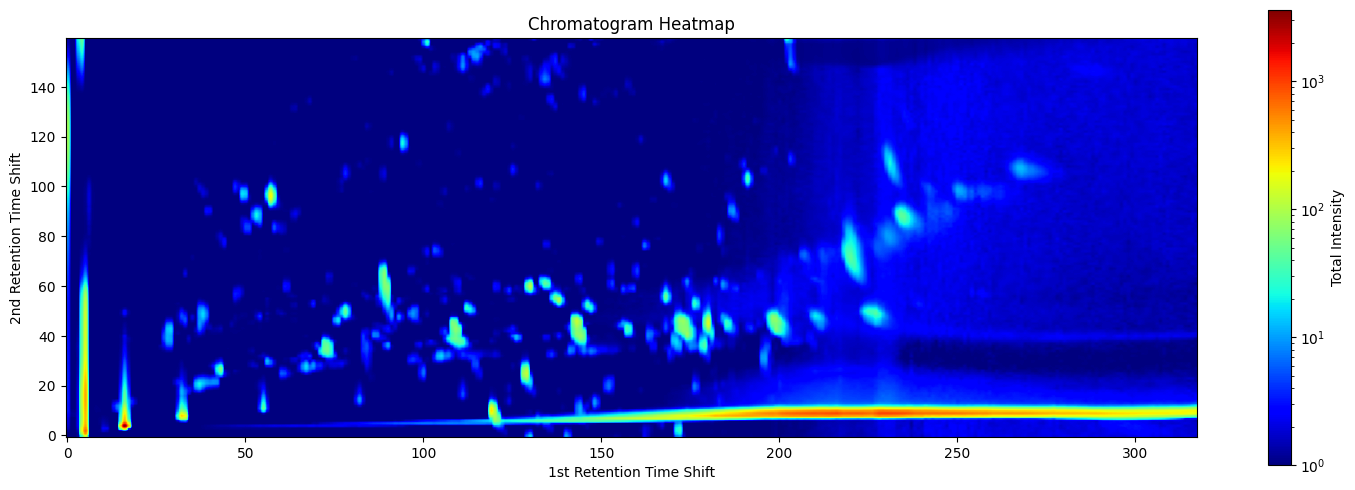

In [7]:
filename = os.path.splitext(config["io_params"]["TARGET_CHROMATOGRAM_FILE"])[0]+"_ALIGNED.cdf"
path = os.path.join(config["io_params"]["OUTPUT_PATH"], filename)
chromato, time_rn= read_only_chroma(path, mod_time=config["instrument_params"]["MODTIME"])
print(f"Chrome shape: {chromato.shape}")

chromato = chromato - chromato.min() + 1

# Create the heatmap
plt.figure(figsize=(15, 5))
plt.imshow(chromato.T, aspect=0.7, cmap='jet', origin='lower',
              norm=LogNorm(vmin=1, vmax=chromato.max()))
plt.colorbar(label='Total Intensity')
plt.xlabel('1st Retention Time Shift')
plt.ylabel('2nd Retention Time Shift')

plt.title('Chromatogram Heatmap')
plt.tight_layout()
plt.show()

In [3]:
config_path = os.path.join(os.getcwd(), "..", "config", "combination_swpa_pbp_config.json")
config = load_config(config_path)
combine_swpa_pbp_alignment(config)

chromato read 3.0891191959381104 s
--- 44.51715302467346 seconds --- to compute full spectra centroid
full spectra computed 45.60864329338074 s
baseline corrected
Converted reference chromatogram to CSV
chromato read 5.868684530258179 s
--- 73.73756790161133 seconds --- to compute full spectra centroid
full spectra computed 74.73847937583923 s
baseline corrected
Converted 1/1 chromatograms to CSV

Scheduling SWPA script with the following arguments:
	- Output directory: /tmp/tmp2wt58q83/2025-01-10_04-34-46_out
	- Reference: /tmp/tmp2wt58q83/G0-1-300123.csv
	- Targets: ['/tmp/tmp2wt58q83/G0-1-250123.csv']

[1] "Received Arguments:"
[1] "   - Output directory: /tmp/tmp2wt58q83/2025-01-10_04-34-46_out"
[1] "   - Reference: /tmp/tmp2wt58q83/G0-1-300123.csv"
[1] "   - Targets:  /tmp/tmp2wt58q83/G0-1-250123.csv"
[1] "Target Path:"
[1] "/tmp/tmp2wt58q83/G0-1-250123.csv"
Running the main script.
Loading chromatograms and alignment points...
Chromatograms loaded successfully.
Loading alignment 

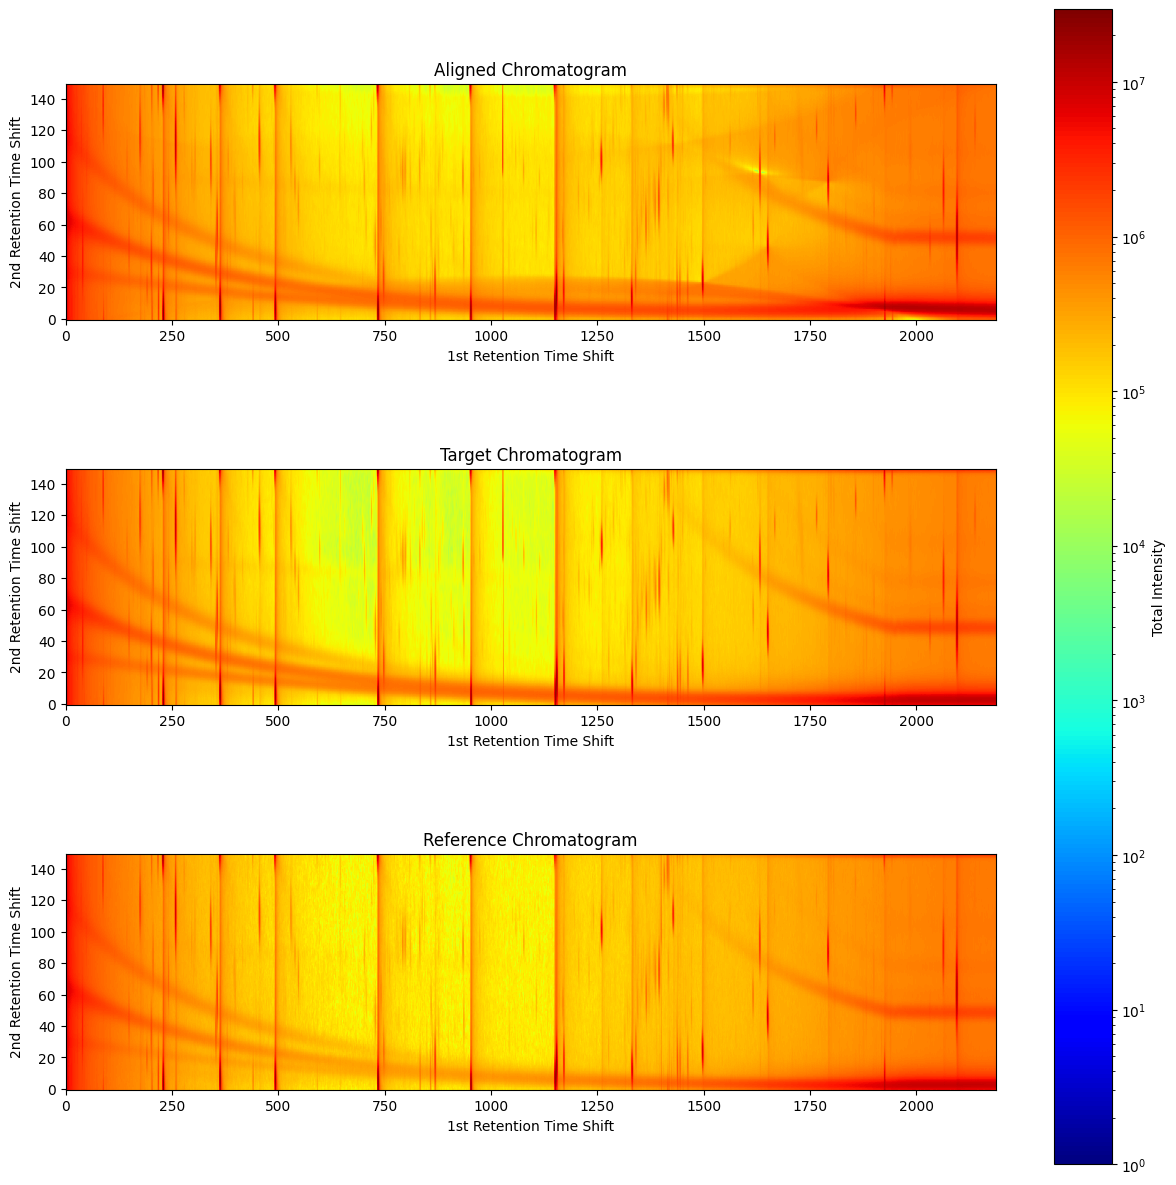

In [27]:
filename = os.path.splitext(config["io_params"]["TARGET_CHROMATOGRAM_FILE"])[0]+"_ALIGNED.cdf"
paths = [
    os.path.join(config["io_params"]["OUTPUT_PATH"], filename),
    os.path.join(config["io_params"]["INPUT_PATH"], config["io_params"]["TARGET_CHROMATOGRAM_FILE"]),
    os.path.join(config["io_params"]["INPUT_PATH"], config["io_params"]["REFERENCE_CHROMATOGRAM_FILE"]),
]
chromato_titles = ['Aligned Chromatogram', 'Target Chromatogram', 'Reference Chromatogram']

chromatos = [read_only_chroma(path, mod_time=config["instrument_params"]["MODTIME"])[0] for path in paths]

fig, axes = plt.subplots(len(chromatos), 1, figsize=(15, 5 * len(chromatos)))

for i, (chromato, ax) in enumerate(zip(chromatos, axes)):
    chromato = chromato - chromato.min() + 1
    ax.imshow(chromato.T, aspect=3.7, cmap='jet', origin='lower',
              norm=LogNorm(vmin=1, vmax=chromato.max()))
    ax.set_title(chromato_titles[i])
    ax.set_xlabel('1st Retention Time Shift')
    ax.set_ylabel('2nd Retention Time Shift')

plt.subplots_adjust(hspace=0)
plt.colorbar(ax.images[0], ax=axes, label='Total Intensity')
plt.show()
